# Strategies

You can initilize a strategy by Python language.

There are many libraries that you can use for defining your trading strategy: you only have to choose what you like best.
In these samples, the library used for trading strategy is [Backtesting.py](https://kernc.github.io/backtesting.py/).

## How to load indicators on your strategy

The best practice is to prepare one column for each indicator that you want to use on your strategy.

In [1]:
!pip install pandas_datareader
# initialization
import numpy as np
import pandas as pd
from pandas_datareader import data as pdr
start='2017-10-30'
end='2020-10-08'
amzn = pdr.DataReader('AMZN', 'yahoo', start, end)
# simple indicators
amzn['SMA20'] = amzn['Close'].rolling(20).mean()
amzn['SMA50'] = amzn['Close'].rolling(50).mean()
amzn['EMA20'] = amzn['Close'].ewm(span=20, adjust=False).mean()
amzn['EMA50'] = amzn['Close'].ewm(span=50, adjust=False).mean()
amzn['STD20'] = amzn['Close'].rolling(20).std()
amzn['Upper Band'] = amzn['SMA20'] + (amzn['STD20'] * 2)
amzn['Lower Band'] = amzn['SMA20'] - (amzn['STD20'] * 2)
#amzn['Upper Band'] = amzn['EMA20'] + (amzn['STD20'] * 2)
#amzn['Lower Band'] = amzn['EMA20'] - (amzn['STD20'] * 2)
def RSI(data, time_window):
    diff = data.diff(1).dropna()
    up_chg = 0 * diff
    down_chg = 0 * diff
    up_chg[diff > 0] = diff[ diff>0 ]
    down_chg[diff < 0] = diff[ diff < 0 ]
    up_chg_avg   = up_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    down_chg_avg = down_chg.ewm(com=time_window-1 , min_periods=time_window).mean()
    rs = abs(up_chg_avg/down_chg_avg)
    rsi = 100 - 100/(1+rs)
    return rsi
amzn['RSI'] = RSI(amzn['Close'], 14)
amzn['RSI70'] = 70.0
amzn['RSI50'] = 50.0
# custom indicator
def RSIaverage(data, n1, n2):
    RSI_1 = RSI(data, n1)
    RSI_2 = RSI(data, n2)
    return (RSI_1 + RSI_2) / 2
amzn['RSIaverage'] = RSIaverage(amzn['Close'], 2, 14)
# data ranges
piece_d = pd.date_range(start='2017-10-30', end='2020-10-01')
#piece_d = pd.date_range(start='2020-01-01', end='2020-10-01')
amzn_piece_d = amzn.reindex(piece_d)
data = pd.DataFrame(amzn_piece_d.dropna())
# sample of divergence signal
divergence = [[('2020-07-22',3250),('2020-09-01',3550)]]
data['divergence'] = np.where((data.index == '2020-07-10') | (data.index == '2020-09-01'), data['RSI'], None)
data['divergence'] = data['divergence'].dropna()

You can have to see your strategy and the plot is your solution. If you have not defined which indicators you want to use, you can see them all together.

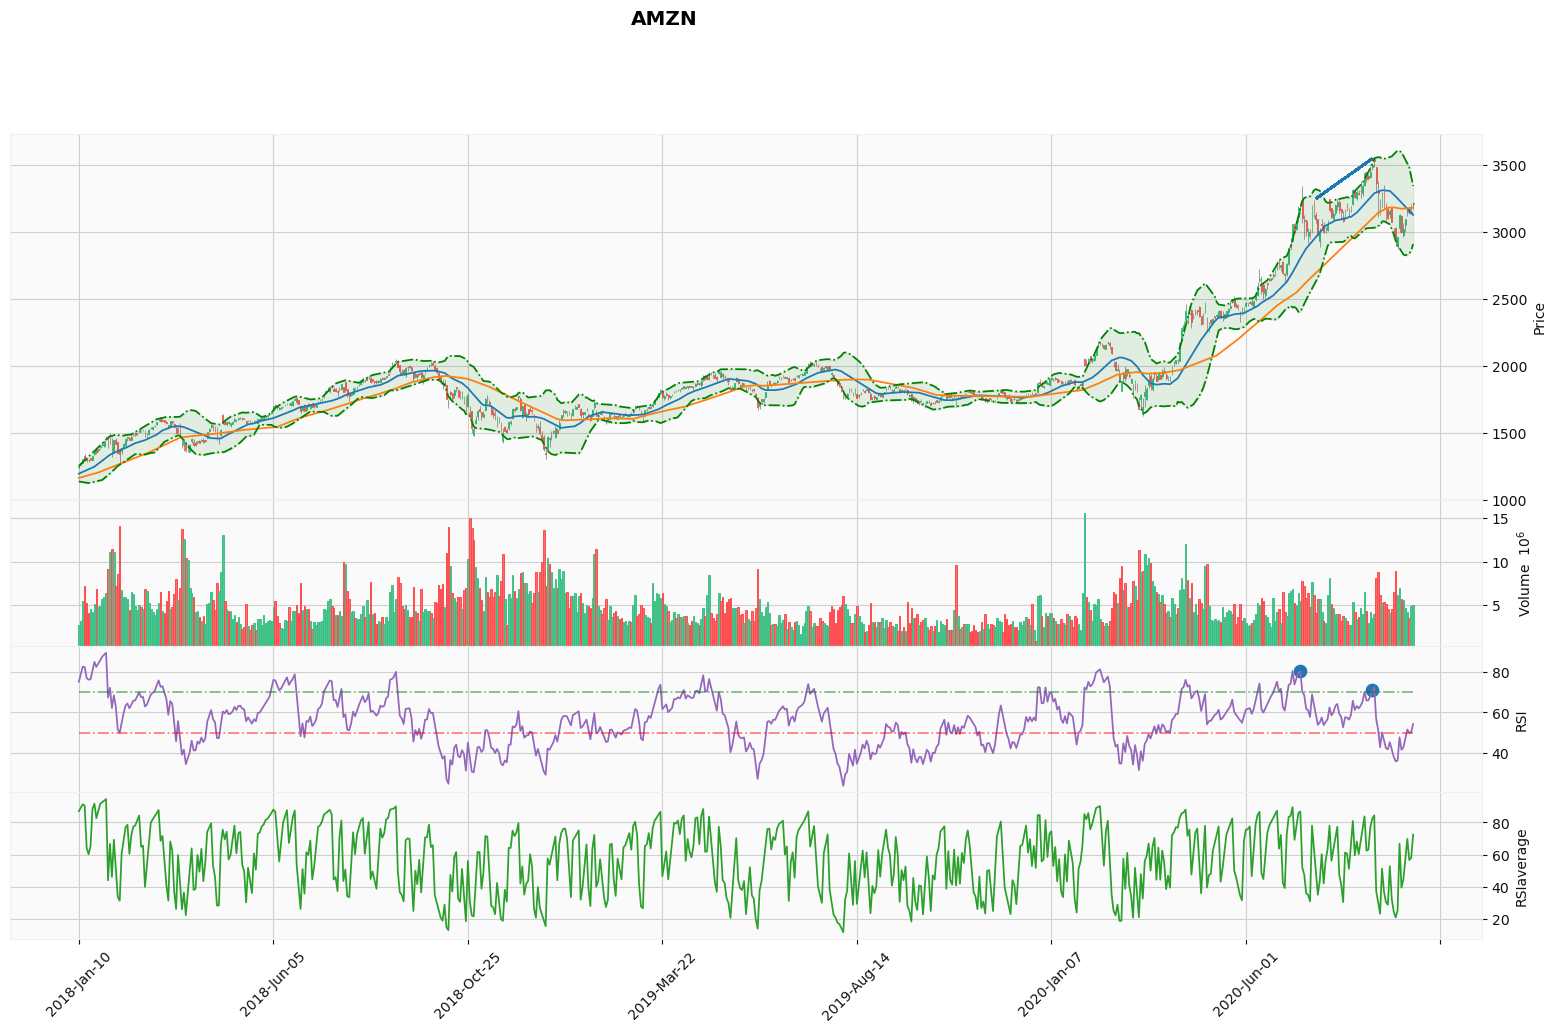

In [2]:
!pip install mplfinance
# plot with candle daily, sma 20, sma 50, bb, RSI and yahoo style
import mplfinance as mpf
kwargs = dict(type='candle',volume=True,figratio=(16,9),figscale=2)
aps = [
    mpf.make_addplot(data['SMA20'],color='C0'), # blue
    mpf.make_addplot(data['SMA50'],color='C1'), # orange
#    mpf.make_addplot(data['EMA20'],color='C0'), # blue
#    mpf.make_addplot(data['EMA50'],color='C1'), # orange
    mpf.make_addplot(data['Upper Band'],linestyle='-.',color='g'),
    mpf.make_addplot(data['Lower Band'],linestyle='-.',color='g'),
    mpf.make_addplot(data['RSI'],color='C4',panel=2,ylabel='RSI'),
    mpf.make_addplot(data['RSI70'],color='g',panel=2,type='line',linestyle='-.',alpha=0.5),
    mpf.make_addplot(data['RSI50'],color='r',panel=2,type='line',linestyle='-.',alpha=0.5),
    mpf.make_addplot(data['divergence'],color='C0',panel=2,type='scatter',markersize=78,marker='o'),
    mpf.make_addplot(data['RSIaverage'],color='C2',panel=3,ylabel='RSIaverage'),
] 
mpf.plot(data,**kwargs,style='yahoo',title='AMZN',addplot=aps,alines=divergence,fill_between=dict(y1=data['Lower Band'].values,y2=data['Upper Band'].values,alpha=0.1,color='g'))
#mpf.plot(data,**kwargs,style='yahoo',title='AMZN',addplot=aps,alines=divergence,fill_between=dict(y1=data['Lower Band'].values,y2=data['Upper Band'].values,alpha=0.1,color='g'),savefig=dict(fname='plot.with.candle.daily.sma.20.sma.50.bb.RSI.yahoo.style.png'))

## How to load signals on your strategy

The best practice is to prepare one column for each signal that you want to use on your strategy.
The strategy below use the moving averages that they are SMA and EMA. You can use one or the other.

### Disclaimer

The strategies below are some simple samples for having an idea how to use the libraries:
those strategies are for the educational purpose only.
All investments and trading in the stock market involve risk:
any decisions related to buying/selling of stocks or other financial instruments should only be made after
a thorough research, backtesting, running in demo and seeking a professional assistance if required.

### Moving Average Crossover Strategy - Sample 1

* when the price value crosses the MA value from below, it will close any existing short position and go long (buy) one unit of the asset
* when the price value crosses the MA value from above, it will close any existing long position and go short (sell) one unit of the asset

Reference: https://www.learndatasci.com/tutorials/python-finance-part-3-moving-average-trading-strategy/

In [3]:
# Moving Average Crossover Strategy - Sample 1
#ma = 'SMA20'
ma = 'EMA20'
# Taking the difference between the prices and the MA timeseries
data['price_ma_diff'] = data['Close'] - data[ma]
# Taking the sign of the difference to determine whether the price or the EMA is greater
data['signal1'] = data['price_ma_diff'].apply(np.sign)
data['position1'] = data['signal1'].diff()
data['buy'] = np.where(data['position1'] == 2, data[ma], np.nan)
data['sell'] = np.where(data['position1'] == -2, data[ma], np.nan)

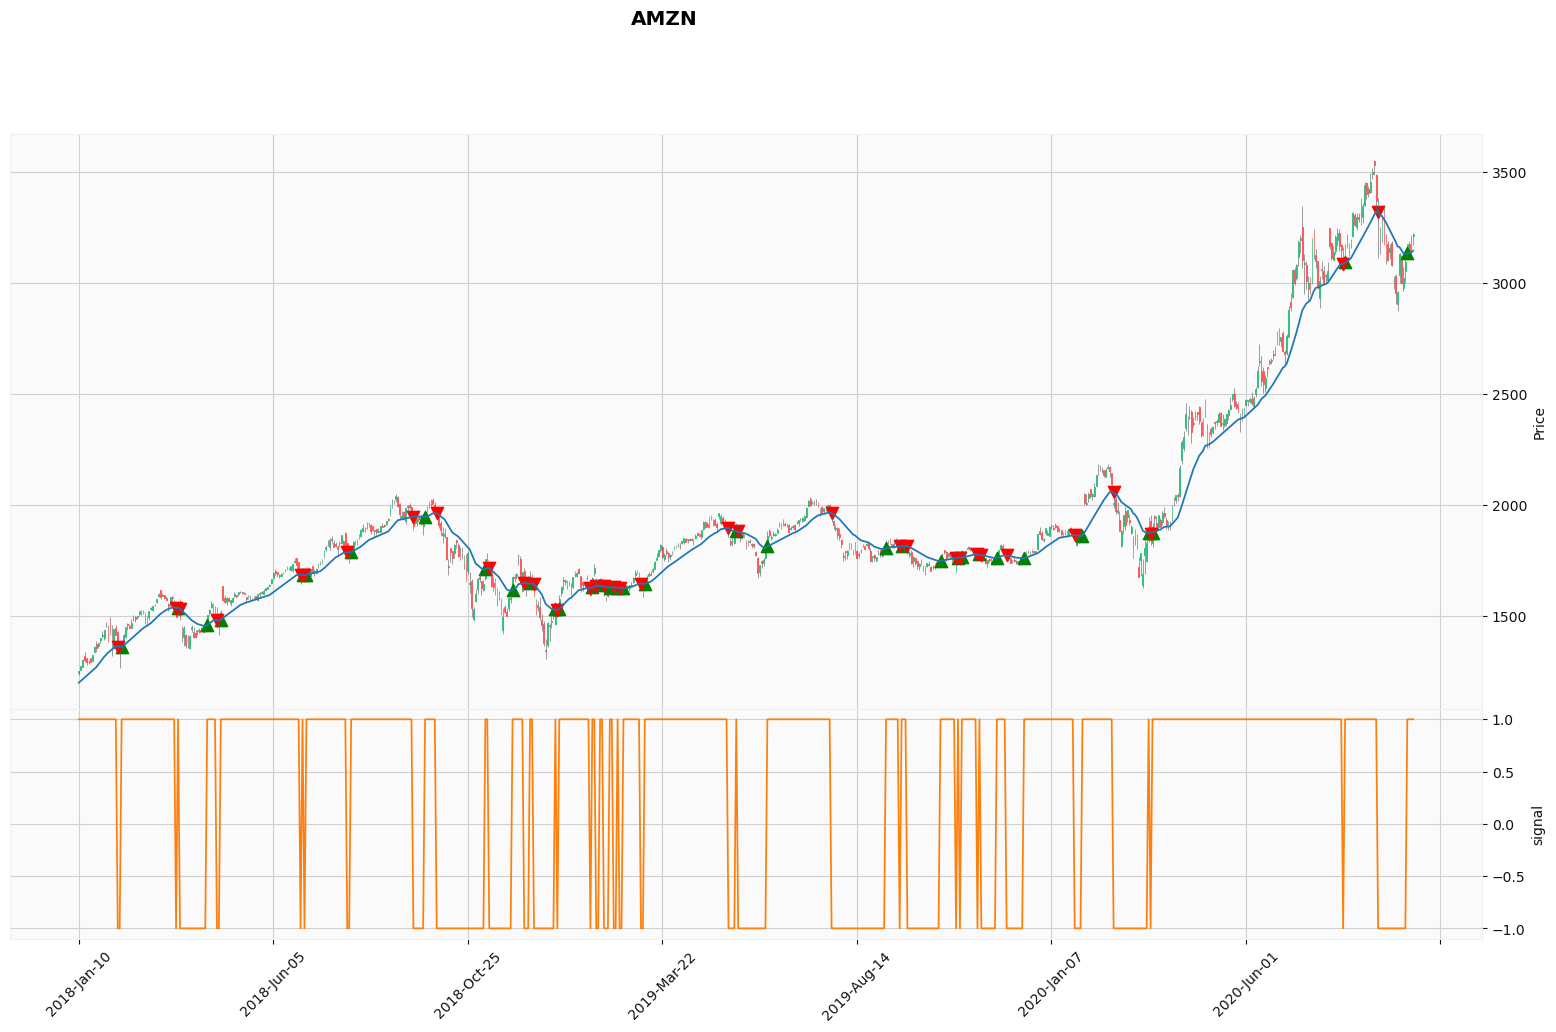

In [4]:
# plot with candle daily, sma 20, signal and yahoo style
import mplfinance as mpf
kwargs = dict(type='candle',figratio=(16,9),figscale=2)
aps = [
    mpf.make_addplot(data[ma],color='C0'), # blue
    mpf.make_addplot(data['buy'],color='g',type='scatter',markersize=78,marker='^'),
    mpf.make_addplot(data['sell'],color='r',type='scatter',markersize=78,marker='v'),
    mpf.make_addplot(data['signal1'],color='C1',panel=1,ylabel='signal')
]
mpf.plot(data,**kwargs,style='yahoo',title='AMZN',addplot=aps)
#mpf.plot(data,**kwargs,style='yahoo',title='AMZN',addplot=aps,savefig=dict(fname='plot.with.candle.daily.sma.20.signal.yahoo.style.png'))

In [5]:
!pip install backtesting
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
class PositionSign(Strategy):
    def init(self):
        self.close = self.data.Close
    def next(self):
        i = len(self.data.Close) - 1
        if self.data.position1[-1] == 2:
            self.position.close()
            self.buy()
        elif self.data.position1[-1] == -2:
            self.position.close()
            self.sell()
bt = Backtest(data, PositionSign, cash=10000, commission=.002, exclusive_orders=True)
bt.run()

/opt/conda/lib/python3.8/site-packages/backtesting/_plotting.py:45: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


Loading BokehJS ...

Start                     2018-01-10 00:00:00
End                       2020-10-01 00:00:00
Duration                    995 days 00:00:00
Exposure Time [%]                     96.9432
Equity Final [$]                      6449.39
Equity Peak [$]                       11361.5
Return [%]                           -35.5061
Buy & Hold Return [%]                 156.811
Return (Ann.) [%]                    -14.8609
Volatility (Ann.) [%]                 25.1543
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -62.3199
Avg. Drawdown [%]                    -17.0591
Max. Drawdown Duration      934 days 00:00:00
Avg. Drawdown Duration      238 days 00:00:00
# Trades                                   68
Win Rate [%]                               25
Best Trade [%]                        58.9442
Worst Trade [%]                       -12.944
Avg. Trade [%]                    

In [6]:
bt.plot()

### Moving Average Crossover Strategy - Sample 2

* when the short term moving average crosses above the long term moving average, this indicates a buy signal
* when the short term moving average crosses below the long term moving average, it may be a good moment to sell

Reference: https://towardsdatascience.com/making-a-trade-call-using-simple-moving-average-sma-crossover-strategy-python-implementation-29963326da7a

In [7]:
# Moving Average Crossover Strategy - Sample 2
ma20 = 'SMA20'
ma50 = 'SMA50'
#ma20 = 'EMA20'
#ma50 = 'EMA50'
data['signal2'] = 0.0
data['signal2'] = np.where(data[ma20] > data[ma50], 1.0, 0.0)
data['position2'] = data['signal2'].diff()
data['buy'] = np.where(data['position2'] == 1, data[ma20], np.nan)
data['sell'] = np.where(data['position2'] == -1, data[ma20], np.nan)

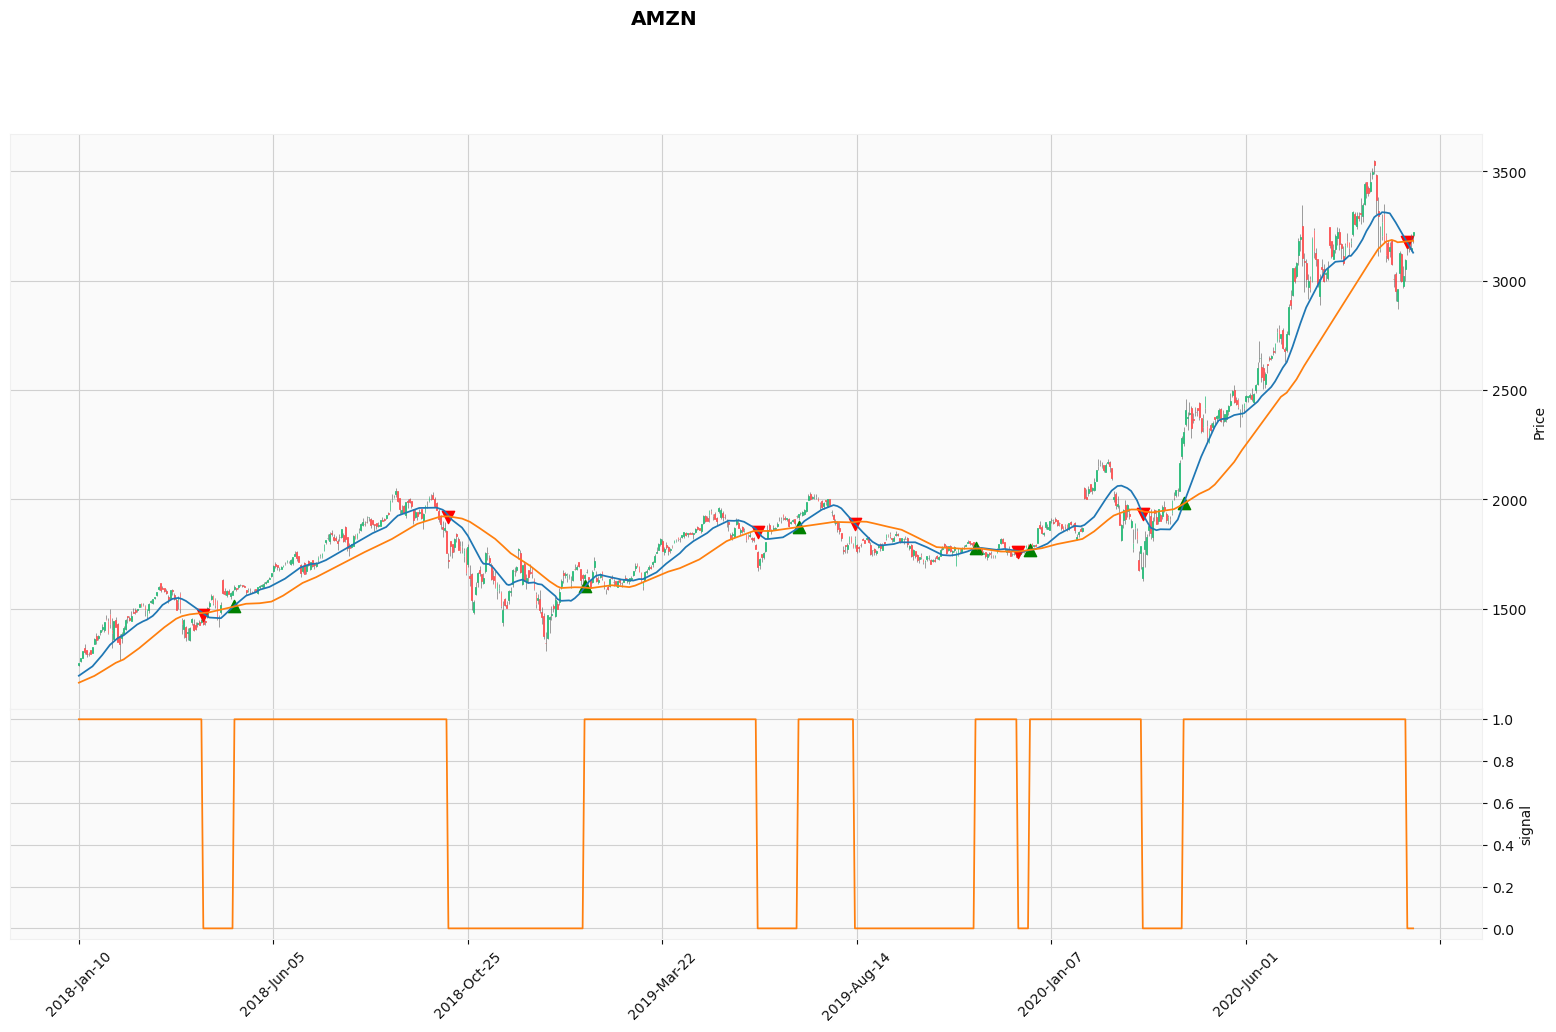

In [8]:
# plot with candle daily, sma 20, sma 50, signal and yahoo style
import mplfinance as mpf
kwargs = dict(type='candle',figratio=(16,9),figscale=2)
aps = [
    mpf.make_addplot(data[ma20],color='C0'), # blue
    mpf.make_addplot(data[ma50],color='C1'), # orange
    mpf.make_addplot(data['buy'],color='g',type='scatter',markersize=78,marker='^'),
    mpf.make_addplot(data['sell'],color='r',type='scatter',markersize=78,marker='v'),
    mpf.make_addplot(data['signal2'],color='C1',panel=1,ylabel='signal')
]
mpf.plot(data,**kwargs,style='yahoo',title='AMZN',addplot=aps)
#mpf.plot(data,**kwargs,style='yahoo',title='AMZN',addplot=aps,savefig=dict(fname='plot.with.candle.daily.sma.20.sma.50.signal.yahoo.style.png'))

In [9]:
from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
class SmaCross(Strategy):
    n1 = 20
    n2 = 50
    def init(self):
        close = self.data.Close
        self.sma1 = self.I(SMA, close, self.n1)
        self.sma2 = self.I(SMA, close, self.n2)
    def next(self):
        if crossover(self.sma1, self.sma2):
            self.position.close()
            self.buy()
        elif crossover(self.sma2, self.sma1):
            self.position.close()
            self.sell()
bt = Backtest(data, SmaCross, cash=10000, commission=.002, exclusive_orders=True)
bt.run()

Start                     2018-01-10 00:00:00
End                       2020-10-01 00:00:00
Duration                    995 days 00:00:00
Exposure Time [%]                     90.5386
Equity Final [$]                      7712.69
Equity Peak [$]                       12532.8
Return [%]                           -22.8731
Buy & Hold Return [%]                 156.811
Return (Ann.) [%]                    -9.08703
Volatility (Ann.) [%]                  24.431
Sharpe Ratio                                0
Sortino Ratio                               0
Calmar Ratio                                0
Max. Drawdown [%]                    -52.0307
Avg. Drawdown [%]                    -11.5153
Max. Drawdown Duration      517 days 00:00:00
Avg. Drawdown Duration       80 days 00:00:00
# Trades                                   13
Win Rate [%]                          38.4615
Best Trade [%]                        35.0832
Worst Trade [%]                      -32.3988
Avg. Trade [%]                    

In [10]:
bt.plot()